In [1]:
import glob
import importlib
import os
import random
import sys
from itertools import combinations

import matplotlib as mpl
import matplotlib.pyplot as plt
import mdtraj as md
import numpy as np
import prettypyplot as ppl
import scipy
import seaborn as sns
import sklearn
from matplotlib import ticker
from sklearn import metrics

import extq
import ivac

In [2]:
sys.path.insert(1, "../../python")
sys.path.insert(1, "../../..")
import plotting
import util

In [3]:
plt.style.use("custom")  # custom style sheet
plt.style.use("muted")  # muted color theme from SciencePlots
cm_seq = sns.cubehelix_palette(
    start=0, rot=-0.70, gamma=0.40, light=0.9, dark=0.1, as_cmap=True, reverse=True
)
cm_seq2 = sns.cubehelix_palette(
    start=0, rot=-0.70, gamma=0.40, light=0.8, dark=0.1, as_cmap=True, reverse=False
)
colors = mpl.colors.to_rgba_array(
    [
        "#364B9A",
        "#4A7BB7",
        "#6EA6CD",
        "#98CAE1",
        "#C2E4EF",
        "#EAECCC",
        "#FEDA8B",
        "#FDB366",
        "#F67E4B",
        "#DD3D2D",
        "#A50026",
    ]
)
cm_div = mpl.colors.LinearSegmentedColormap.from_list("", colors)

In [4]:
%config InlineBackend.figure_format = "retina"

# Load data

In [5]:
DATA_DIR = "/project/dinner/scguo/ci-vsd/data"
# S4 translocation/rotation data
cv_trajs = list(
    np.load(f"{DATA_DIR}/raw_feat/cv_dist_spin_anton.npy", allow_pickle=True)
)
cv_trajs.extend(np.load(f"{DATA_DIR}/raw_feat/cv_dist_spin_anton2.npy"))
cv_arr = np.concatenate(cv_trajs)
# salt bridge distances for states
sb_trajs = list(np.load(f"{DATA_DIR}/raw_feat/feat2_raw_anton.npy", allow_pickle=True))
sb_trajs.extend(np.load(f"{DATA_DIR}/raw_feat/feat2_raw_anton2.npy"))
sb_arr = np.concatenate(sb_trajs)
sb_models = np.load(f"{DATA_DIR}/models_centroids_feat2.npy")

rf161 = list(np.load(f"{DATA_DIR}/raw_feat/rf161.npy", allow_pickle=True))
rf161.extend(np.load(f"{DATA_DIR}/raw_feat/rf161_anton2.npy"))
rf161_arr = np.concatenate(rf161)
print(cv_arr.shape, sb_arr.shape, rf161_arr.shape)

(4840184, 2) (4840184, 60) (4840184, 3)


In [6]:
dist = cv_arr[:, 0]
rot = cv_arr[:, 1]
sb1 = sb_arr[:, 42]  # R226-D129
sb2 = sb_arr[:, 47]  # R226-D186
sb3 = sb_arr[:, 48]  # R229-D129
sb4 = sb_arr[:, 53]  # R229-D186
sb5 = sb_arr[:, 59]  # R232-D186


# ellipse centered at down centroid with radii 1.1 nm and 8 deg (1 sigma in each direction)
# take points where R2-D186 < 0.5 (lower salt bridges), R2-D129 > 0.6 (upper salt bridge)
dist_ax_down = (dist + 4.240) / 1.1
rot_ax_down = (rot + 56.95) / 8
down_ids = ((dist_ax_down ** 2 + rot_ax_down ** 2) < 1) & (sb1 > 0.6) & (sb2 < 0.5)

# ellipse centered at up centroid with radii 0.84 nm and 7.6 deg (2 sigma in each direction)
# take points where R2-D129 (up) < 0.5, R3-D129 < 1.1, R3/R4-D186 salt bridges < 0.75/0.6 nm
up_ids = (
    ((((dist + 0.506) / 0.84) ** 2 + ((rot - 3.94) / 7.6) ** 2) < 1)
    & (sb1 < 0.5)
    & (sb3 < 1.1)
    & (sb4 < 0.75)
    & (sb5 < 0.6)
)

In [8]:
mask = ~(down_ids | up_ids)

# len(**_ids) is number of points in each state
down = sb_arr[down_ids]
up = sb_arr[up_ids]
other = sb_arr[mask]

# split CV data
down_cvs = cv_arr[down_ids]
up_cvs = cv_arr[up_ids]
other_cvs = cv_arr[mask]
down_sbs = sb_arr[down_ids]
up_sbs = sb_arr[up_ids]
other_sbs = cv_arr[mask]

In [9]:
assert (
    np.count_nonzero(down_ids) + np.count_nonzero(up_ids) + np.count_nonzero(mask)
) == len(cv_arr)
print(f"Number of down structures:  {len(down)}")
print(f"Number of up structures:   {len(up)}")
print(f"Number of other structures: {len(other)}")

Number of down structures:  56647
Number of up structures:   5402
Number of other structures: 4778135


In [10]:
random.seed(123)
s = 20
N = len(cv_arr)
inds = random.sample(range(N), N // s)

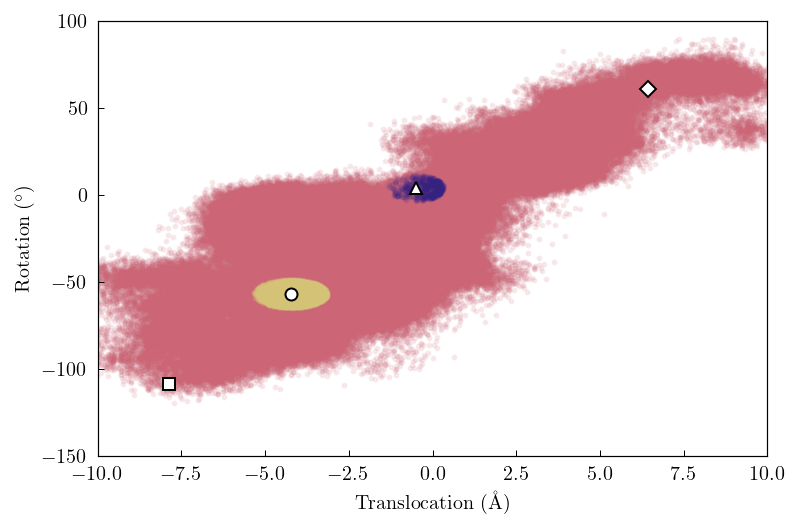

In [11]:
plt.figure()
plt.scatter(other_cvs[::10, 0], other_cvs[::10, 1], alpha=0.1)
plt.scatter(up_cvs[::10, 0], up_cvs[::10, 1], alpha=0.1)
plt.scatter(down_cvs[::10, 0], down_cvs[::10, 1], alpha=0.1)
ax = plt.gca()
plotting.format_cvs(ax, ms=6)

## compute distance to states

In [12]:
# compute minimum distance (minimum of column) from domain to dimeric/monomeric state
def reduce_func(D_chunk, start):
    min2 = np.min(D_chunk, axis=1)
    return min2

In [13]:
d_down = []
counter = 0.0
tot = len(sb_arr)
skip = 2

for chunk in metrics.pairwise_distances_chunked(
    sb_arr, down[::skip], n_jobs=-1, reduce_func=reduce_func
):
    d_down.append(chunk)
    counter += float(len(chunk))
    perc = counter / tot * 100
    print(f"{perc:.2f}% completed")

0.10% completed
0.20% completed
0.29% completed
0.39% completed
0.49% completed
0.59% completed
0.69% completed
0.78% completed
0.88% completed
0.98% completed
1.08% completed
1.17% completed
1.27% completed
1.37% completed
1.47% completed
1.57% completed
1.66% completed
1.76% completed
1.86% completed
1.96% completed
2.06% completed
2.15% completed
2.25% completed
2.35% completed
2.45% completed
2.55% completed
2.64% completed
2.74% completed
2.84% completed
2.94% completed
3.03% completed
3.13% completed
3.23% completed
3.33% completed
3.43% completed
3.52% completed
3.62% completed
3.72% completed
3.82% completed
3.92% completed
4.01% completed
4.11% completed
4.21% completed
4.31% completed
4.40% completed
4.50% completed
4.60% completed
4.70% completed
4.80% completed
4.89% completed
4.99% completed
5.09% completed
5.19% completed
5.29% completed
5.38% completed
5.48% completed
5.58% completed
5.68% completed
5.78% completed
5.87% completed
5.97% completed
6.07% completed
6.17% co

In [14]:
# Set all distances of point in down state to be 0 explicitly
d_down_arr = np.reshape(np.concatenate(d_down), (-1, 1))
d_down_arr[down_ids] = 0

print(d_down_arr.shape)

(4840184, 1)


In [15]:
d_up = []
counter = 0.0
skip = 1

for chunk in metrics.pairwise_distances_chunked(
    sb_arr, up[::skip], n_jobs=-1, reduce_func=reduce_func
):
    d_up.append(chunk)
    counter += float(len(chunk))
    perc = counter / tot * 100
    print(f"{perc:.2f}% completed")

0.51% completed
1.03% completed
1.54% completed
2.05% completed
2.57% completed
3.08% completed
3.59% completed
4.11% completed
4.62% completed
5.13% completed
5.65% completed
6.16% completed
6.67% completed
7.19% completed
7.70% completed
8.21% completed
8.73% completed
9.24% completed
9.75% completed
10.27% completed
10.78% completed
11.29% completed
11.81% completed
12.32% completed
12.83% completed
13.35% completed
13.86% completed
14.37% completed
14.89% completed
15.40% completed
15.91% completed
16.43% completed
16.94% completed
17.45% completed
17.97% completed
18.48% completed
18.99% completed
19.51% completed
20.02% completed
20.53% completed
21.05% completed
21.56% completed
22.07% completed
22.59% completed
23.10% completed
23.61% completed
24.13% completed
24.64% completed
25.15% completed
25.67% completed
26.18% completed
26.69% completed
27.21% completed
27.72% completed
28.23% completed
28.75% completed
29.26% completed
29.77% completed
30.29% completed
30.80% completed

In [16]:
# Set all distances of point in up state to be 0 explicitly
d_up_arr = np.reshape(np.concatenate(d_up), (-1, 1))
d_up_arr[up_ids] = 0

print(d_up_arr.shape)

(4840184, 1)


In [17]:
np.save("../../data/feat2_dist_du_anton2/dist_down_5", d_down_arr)
np.save("../../data/feat2_dist_du_anton2/dist_up_5", d_up_arr)

## Basis and smoothing

In [18]:
# make smoothing function
smooth = (d_down_arr * d_up_arr) ** 0.5 / (d_down_arr + d_up_arr)

# make guess
guess_down = (d_up_arr ** 2) / (d_down_arr ** 2 + d_up_arr ** 2)
guess_up = (d_down_arr ** 2) / (d_down_arr ** 2 + d_up_arr ** 2)

# make smoothing 0 at boundaries (down and up states)
smooth[~mask] = 0
# ensure homogeneous boundary conditions for guess
guess_up[up_ids] = 1
guess_up[down_ids] = 0
guess_down[down_ids] = 1
guess_down[up_ids] = 0
print(smooth.shape, guess_down.shape, guess_up.shape)

(4840184, 1) (4840184, 1) (4840184, 1)


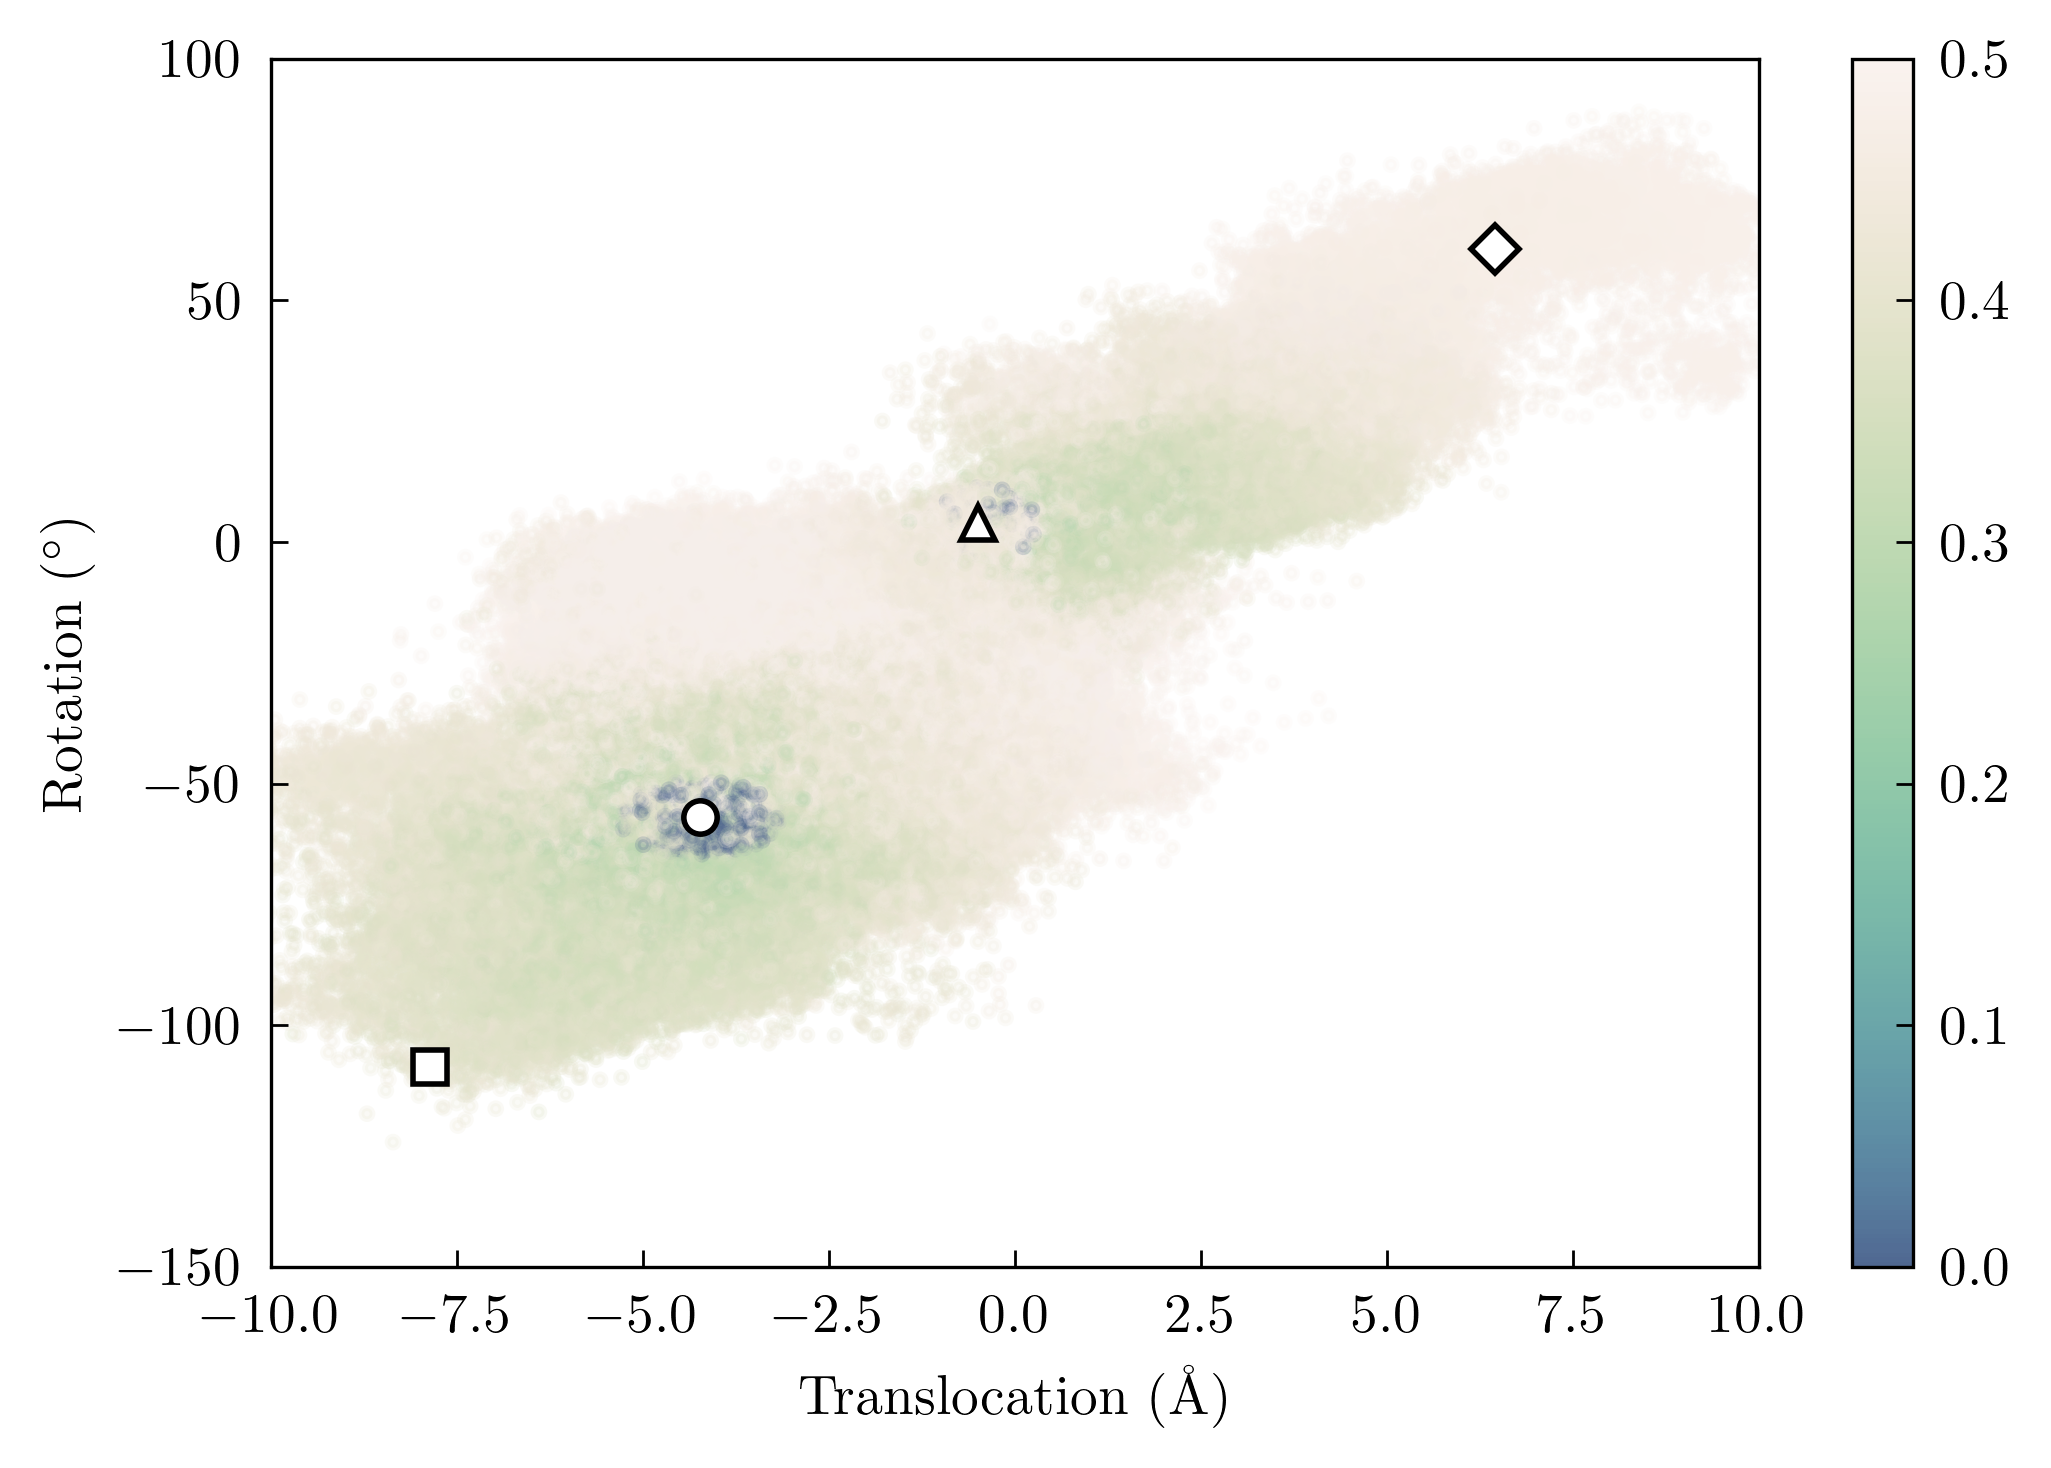

In [19]:
# Plot smoothing function
fig, ax = plt.subplots(dpi=200)
h = ax.scatter(cv_arr[inds, 0], cv_arr[inds, 1], c=smooth[inds], alpha=0.2, cmap=cm_seq)

cb = plt.colorbar(h, ax=ax)
cb.solids.set(alpha=1.0)
plotting.format_cvs(ax, ms=6)

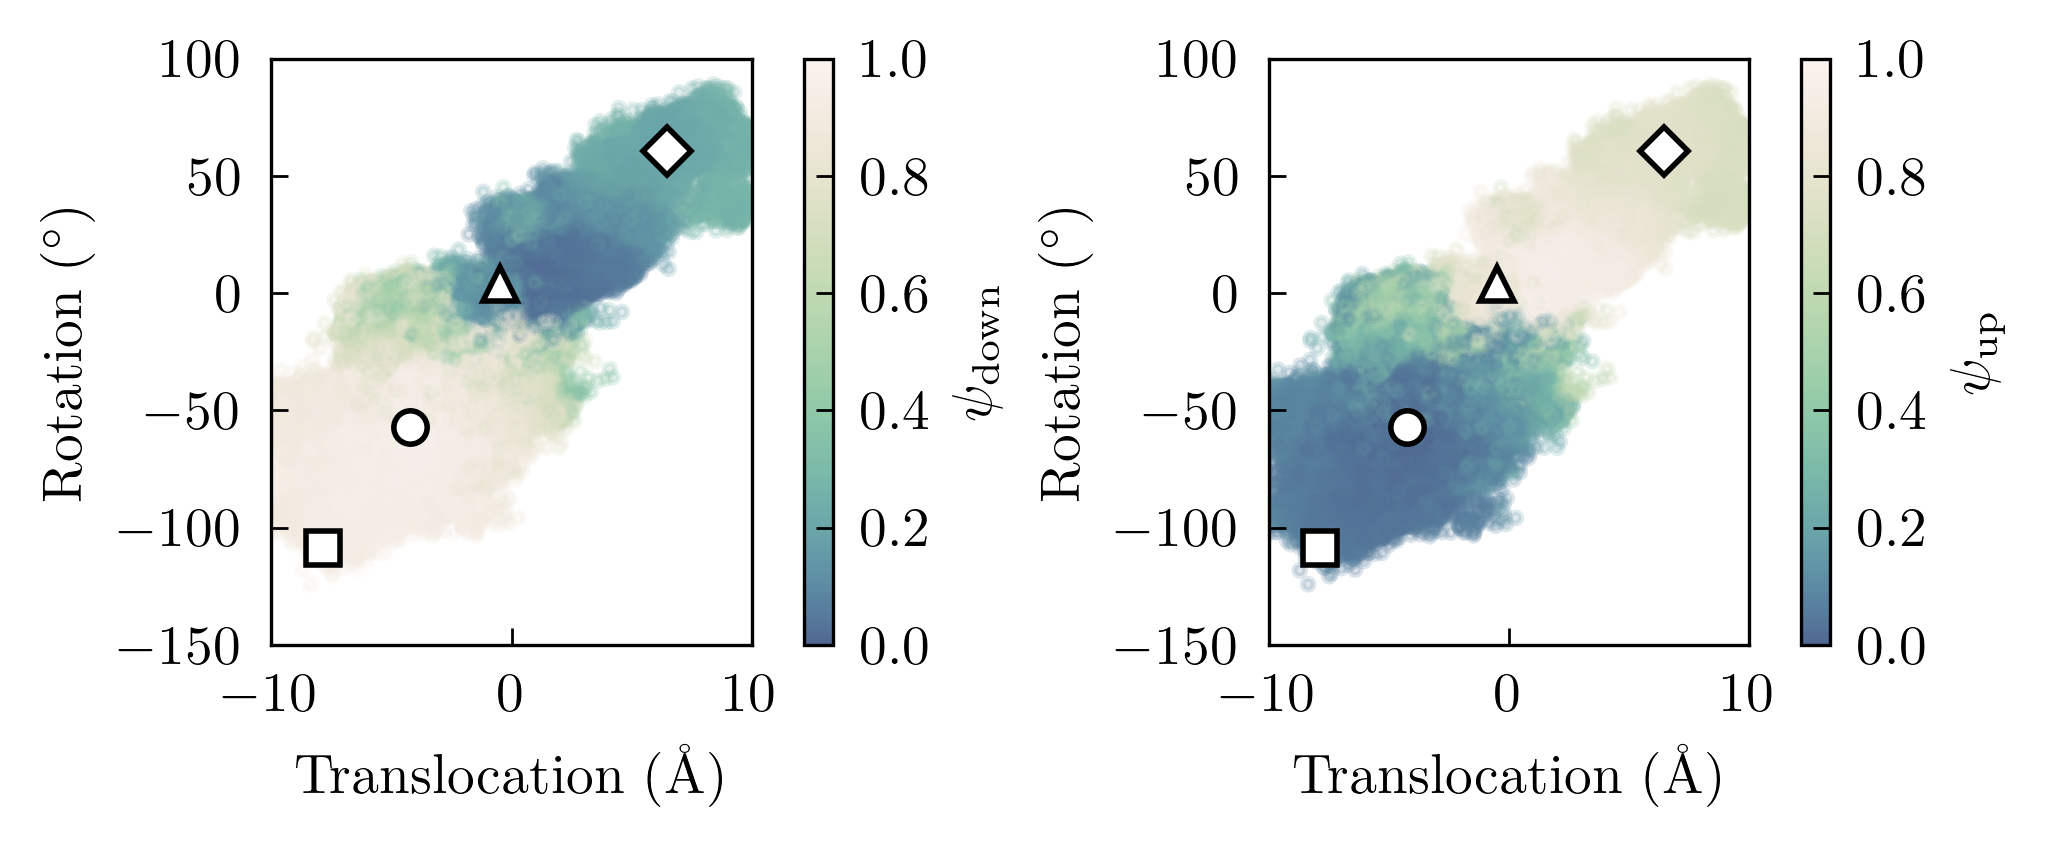

In [20]:
# Plot down and up state guess function
fig, axs = plt.subplots(1, 2, figsize=(5, 2), dpi=200, constrained_layout=True)
labels = ("$\psi_{\mathrm{down}}$", "$\psi_{\mathrm{up}}$")
for ax, g, label in zip(axs, (guess_down, guess_up), labels):
    h = ax.scatter(cv_arr[inds, 0], cv_arr[inds, 1], c=g[inds], alpha=0.2, cmap=cm_seq)
    cb = plt.colorbar(h, ax=ax, label=label)
    cb.solids.set(alpha=1.0)
    plotting.format_cvs(ax, ms=6)

# Weights

In [21]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.neighbors import NearestNeighbors

### Feature5/IVAC weights

In [22]:
# load feature 5
with np.load(f"{DATA_DIR}/raw_feat/feat5_raw.npz", allow_pickle=True) as f:
    feat5_raw = list(f['arr_0'])
with np.load(f"{DATA_DIR}/raw_feat/feat5_raw_anton2.npz") as f:
    feat5_raw.extend(f['arr_0'])
print(len(feat5_raw), feat5_raw[-1].shape)

421 (10001, 1924)


In [ ]:
# reduce dimensions with IVAC
livac = ivac.LinearIVAC(minlag=10, maxlag=5000, nevecs=10, reweight=False, adjust=True)
livac.fit(feat5_raw)

ivac_trajs = livac.transform(feat5_raw)
ivac_arr = np.concatenate(ivac_trajs)

In [24]:
print(ivac_arr.shape)

(4840184, 10)


In [25]:
np.save("../../data/raw_feat/feat5_ivac_anton2_5.npy", ivac_trajs)

/project/dinner/scguo/anaconda3/envs/py39/lib/python3.9/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


In [26]:
del feat5_raw

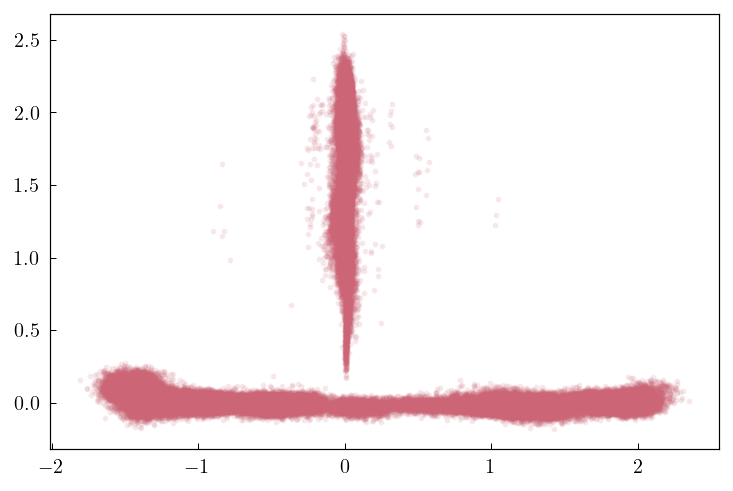

In [27]:
plt.scatter(ivac_arr[inds, 1], ivac_arr[inds, 2], alpha=0.1)

In [28]:
# cluster IVAC points with K-means
km_ivac = MiniBatchKMeans(n_clusters=200)
km_ivac.fit(ivac_arr)

centers = km_ivac.cluster_centers_
neighbors = NearestNeighbors(n_neighbors=1)
neighbors.fit(centers)

NearestNeighbors(n_neighbors=1)

In [29]:
dtrajs_ivac = neighbors.kneighbors(ivac_arr, return_distance=False)
print(dtrajs_ivac.shape)

(4840184, 1)


In [30]:
np.save("../../data/raw_feat/feat5_ivac_ind200_anton2_5", dtrajs_ivac)

## weight basis

In [31]:
# split into lists of arrays
traj_inds = util.split_indices(cv_trajs)
# remove one basis function
basisL_arr = util.make_sparse_basis(np.squeeze(dtrajs_ivac))[:, :-1]

traj_lens = [len(traj) for traj in cv_trajs]
basisL = []
curr = 0
for t_len in traj_lens:
    basisL.append(basisL_arr[curr : curr + t_len])
    curr += t_len
guessU = np.split(np.squeeze(guess_up), traj_inds)
guessD = np.split(np.squeeze(guess_down), traj_inds)

print(len(basisL), basisL[0].shape)
print(len(guessU))
print(len(guessD))

421 (10000, 199)
421
421


In [32]:
lags = [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000]

In [33]:
weights = []
for lag in lags:
    weights.append(extq.dga.reweight(basisL, lag))

In [34]:
len(weights[0]), len(weights[0][0])

(421, 10000)

In [40]:
# np.save("../../data/feat2_dist_du_anton2/weights_3.npy", weights)
np.save("../../data/feat2_dist_du_anton2/weights_5_feat5ivac", weights)
# weights = np.load("../../data/feat2_dist_du_anton2/weights_3_feat5ivac.npy", allow_pickle=True)

/project/dinner/scguo/anaconda3/envs/py39/lib/python3.9/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


## PMFs

In [35]:
# PMFs
dist_trajs = [traj[:, 0] for traj in cv_trajs]
rot_trajs = [traj[:, 1] for traj in cv_trajs]
xlim = np.linspace(-10, 10, 100)
ylim = np.linspace(-150, 100, 100)

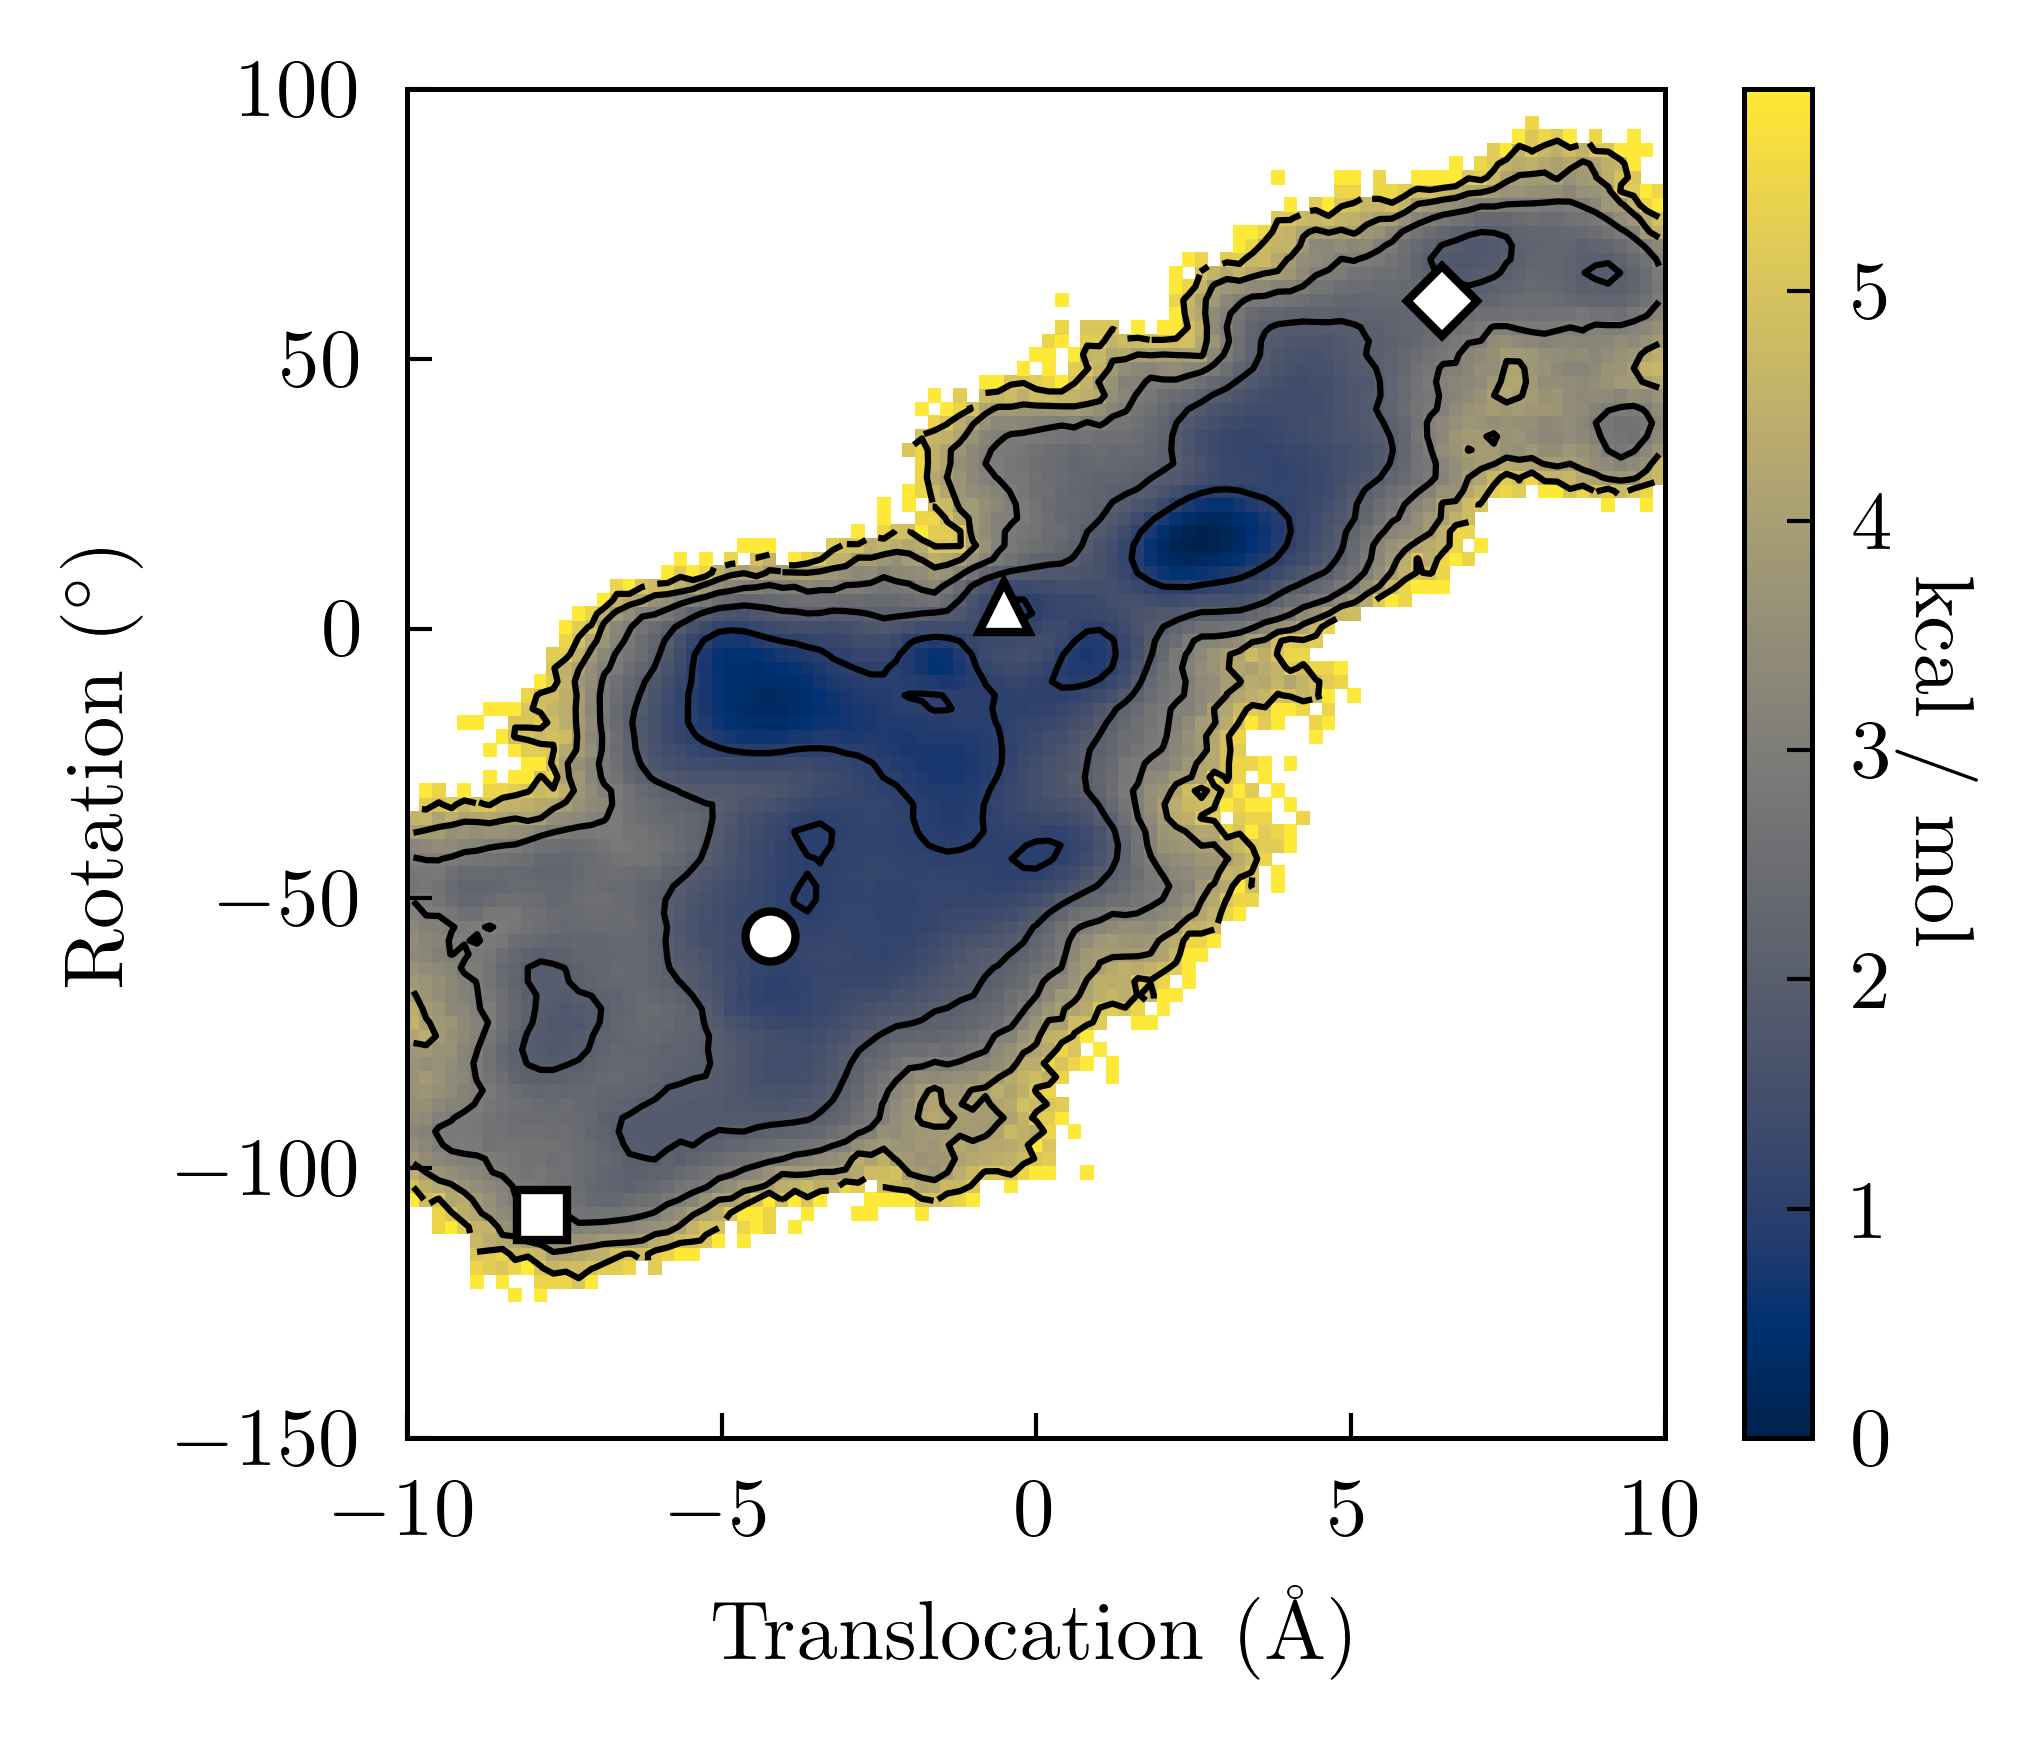

In [39]:
pmf = extq.projection.density2d(dist_trajs, rot_trajs, weights[0], xlim, ylim)
clines = np.linspace(0, 6, 7)
centerx = (xlim[1:] + xlim[:-1]) / 2
centery = (ylim[1:] + ylim[:-1]) / 2

f, ax = plt.subplots(figsize=(3.5, 3), dpi=300)

# calculate energy difference against minimum
ax, h = plotting.plot_pmf(ax, pmf, xlim, ylim, units="kcal", clines=clines, cmap='cividis')
cb = plt.colorbar(h, ax=ax)
cb.set_label("kcal / mol", rotation=-90, labelpad=10)
plotting.format_cvs(ax, centroids=True, ms=6)
f.tight_layout()

In [41]:
# PMFs in sb space
sb_ids = [42, 48, 47, 53]
pmfs_sb = []
xlim = np.linspace(0.3, 2.0, 100)
ylim = np.linspace(0.3, 2.0, 100)
for (sb1, sb2) in combinations(sb_ids, 2):
    sb1_trajs = [traj[:, sb1] for traj in sb_trajs]
    sb2_trajs = [traj[:, sb2] for traj in sb_trajs]
    pmfs_sb.append(
        extq.projection.density2d(sb1_trajs, sb2_trajs, weights[0], xlim, ylim)
    )

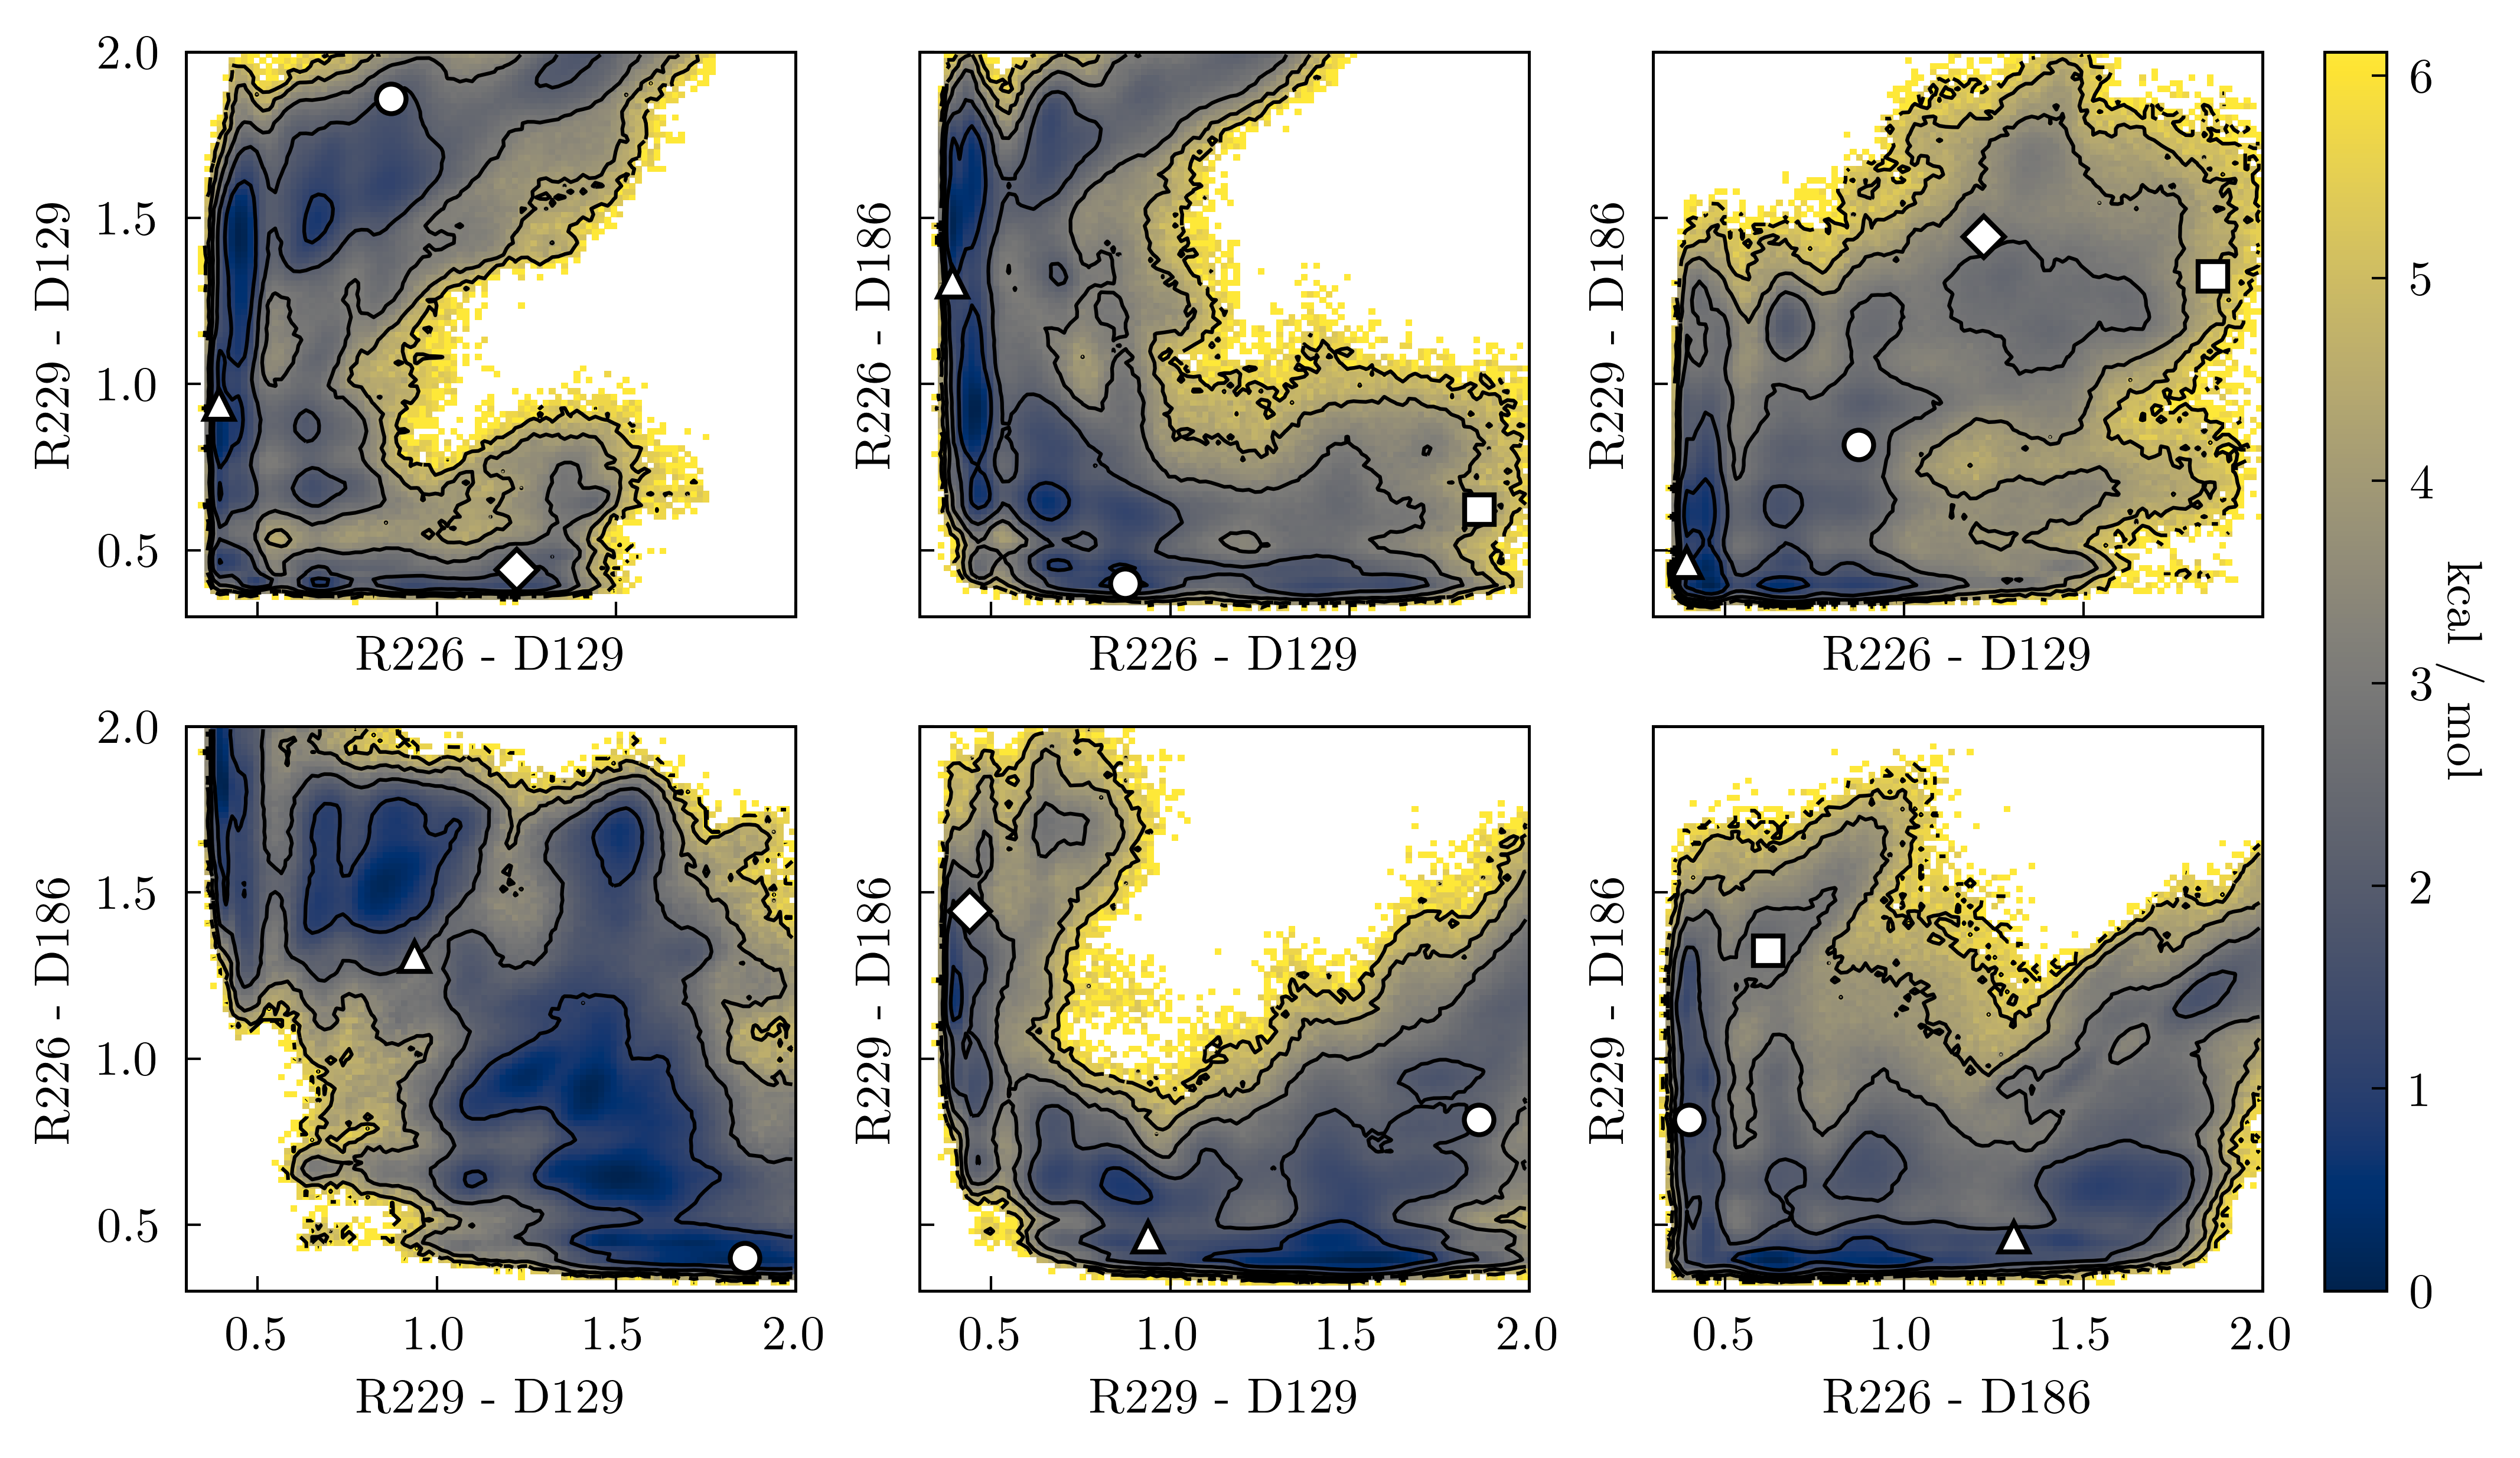

In [42]:
fig_settings = {
    "figsize": (7, 4),
    "sharex": True,
    "sharey": True,
    "constrained_layout": True,
    "dpi": 300,
}
# compute grid
f, axes = plotting.plot_sb_pmfs(
    sb_ids, pmfs_sb, [xlim] * 6, [ylim] * 6, units="kcal", fig_kwargs=fig_settings, ms=6, cmap='cividis'
)
plotting.plot_sb_models(axes.flat, mode="du", centroids=True, ms=6)

# Committors

## Basis

In [43]:
basisF_arr = smooth * sb_arr
basisF = []
curr = 0
for t_len in traj_lens:
    basisF.append(basisF_arr[curr : curr + t_len])
    curr += t_len

basis_d = util.orthogonalize(basisF, weights[0])

In [44]:
assert np.all(np.concatenate(basis_d)[~mask] == False)

## Calculations

In [45]:
traj_inds = util.split_indices(cv_trajs)
in_domain = np.split(mask, traj_inds)
print(in_domain[0].shape)

(10000,)


In [46]:
q_downup, qb_downup = [], []
for (lag, com) in zip(lags, weights):
    print(f"Calculating committors for lag {lag}")
    q_downup.append(extq.dga.forward_committor(basis_d, com, in_domain, guessU, lag))
    qb_downup.append(extq.dga.backward_committor(basis_d, com, in_domain, guessD, lag))

Calculating committors for lag 1
Calculating committors for lag 2
Calculating committors for lag 5
Calculating committors for lag 10
Calculating committors for lag 20
Calculating committors for lag 50
Calculating committors for lag 100
Calculating committors for lag 200
Calculating committors for lag 500
Calculating committors for lag 1000


In [47]:
np.save("../../data/feat2_dist_du_anton2/qp_downup_5", q_downup)
np.save("../../data/feat2_dist_du_anton2/qm_downup_5", qb_downup)

/project/dinner/scguo/anaconda3/envs/py39/lib/python3.9/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


## plot with lag time

In [48]:
from extq.stop import forward_stop

In [64]:
i = 7
lag = lags[i]
dist_trajs_delay = [t[:-lag, 0] for t in cv_trajs]
rot_trajs_delay = [t[:-lag, 1] for t in cv_trajs]
w_delay = [w[:-lag] for w in weights[i]]

q_delay = []
for d, t in zip(in_domain, q_downup[i]):
    # find first stopping time
    stop_times = np.minimum(np.arange(lag, len(d)), forward_stop(d)[:-lag])
    q_delay.append(t[stop_times])

(-130.0, 85.0)

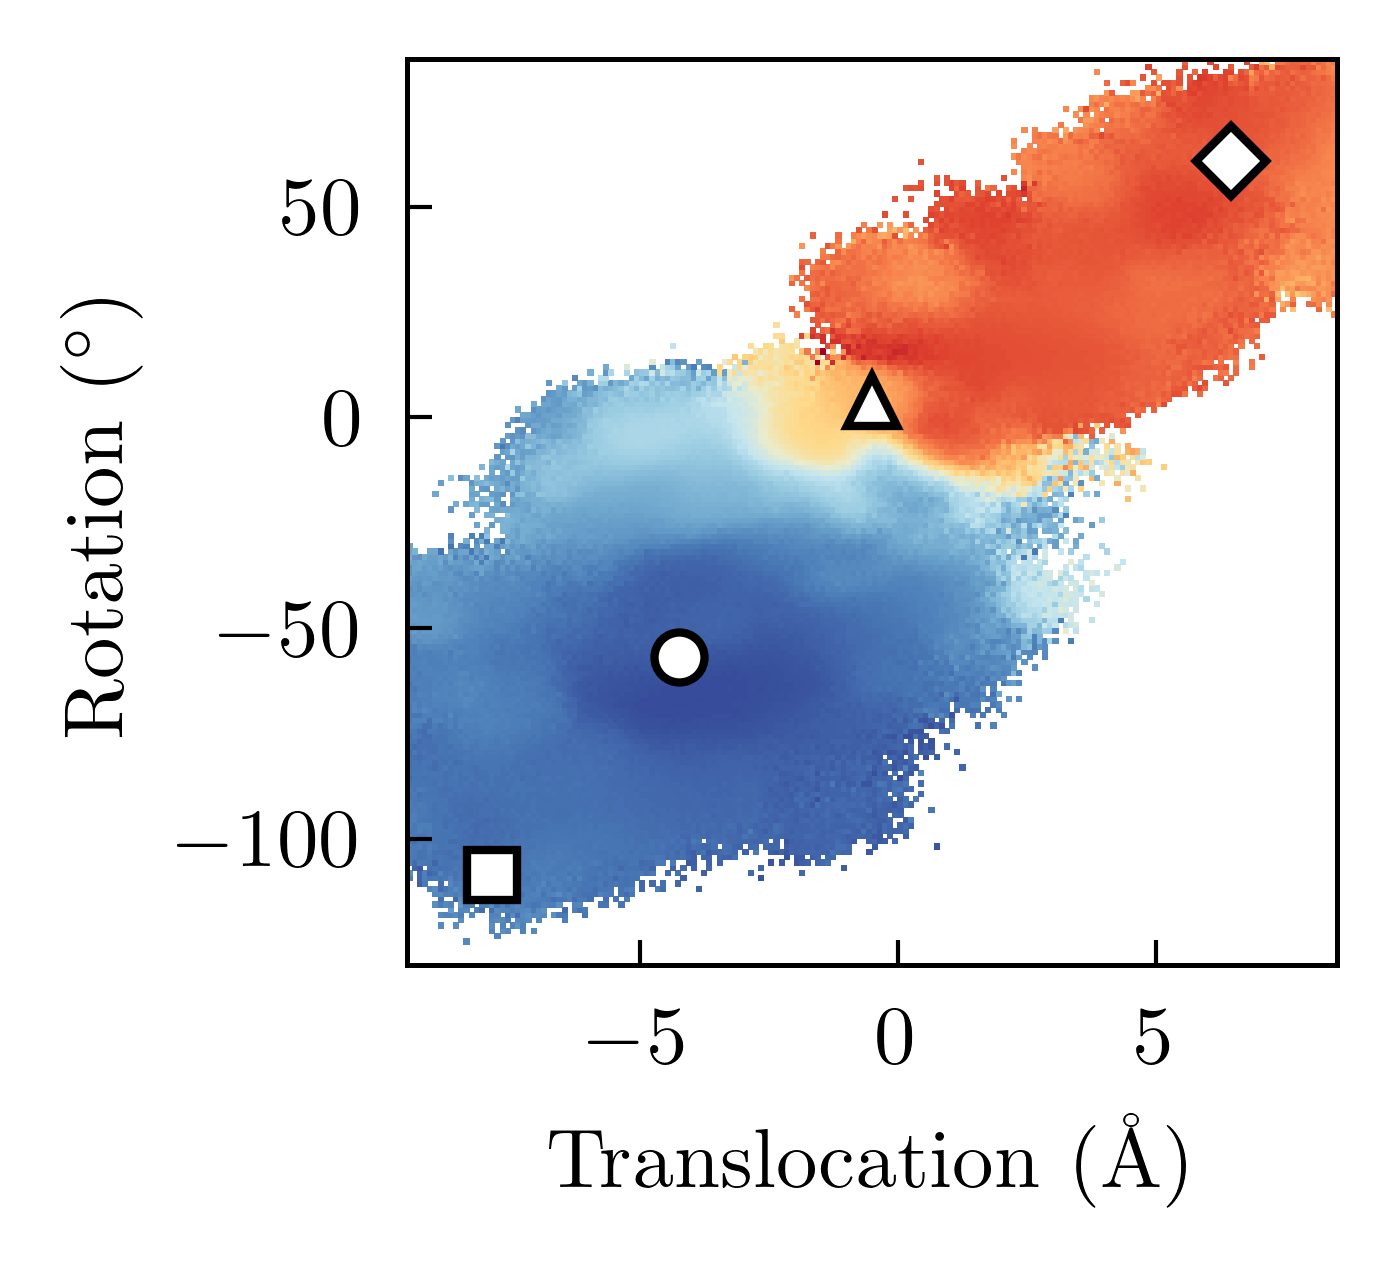

In [65]:
f, ax = plt.subplots(figsize=(2, 2), dpi=300)
xmin, xmax, ymin, ymax = -9.5, 8.5, -130, 85

xe = np.linspace(-10, 10, 201)
ye = np.linspace(-150, 100, 201)
q_dens = extq.projection.average2d(
    dist_trajs_delay, rot_trajs_delay, q_delay, w_delay, xe, ye
)
# plot committors
pc = ax.pcolor(xe, ye, q_dens.T, cmap=cm_div, vmin=0, vmax=1)
plotting.format_cvs(ax, centroids=True, ms=6)
ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])